In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
import gc

Using TensorFlow backend.


In [2]:
# function for clearning train data!
# + remove IP
def clear_data(df, option):
    
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['weekday'] = df['click_time'].dt.dayofweek
    df['hour'] = df['click_time'].dt.hour
    df = df.drop(columns=['ip','click_time'])
    if (option == 'train'):
        y = df['is_attributed']
        df = df.drop(columns=['is_attributed','attributed_time'], axis=1)
        return df, y
    elif (option == 'test'):
        sub_id = df['click_id']
        df = df.drop(columns=['click_id'], axis=1)
        return df, sub_id
    
    

In [3]:
print('load 10% training sample + train/val')
df = pd.read_csv('input_data/train_sampling5.csv')
df, y = clear_data(df,'train')
x_train, x_val, y_train, y_val = train_test_split(df,y,test_size=0.1)

x_train= x_train.drop(columns=['Unnamed: 0'])
x_val= x_val.drop(columns=['Unnamed: 0'])

print(x_train.head(2))
print(x_val.head(2))
print(y_train.head(2))
print(y_val.head(2))
del df, y; gc.collect()

load 10% training sample + train/val
         app  device  os  channel  weekday  hour
4448921   12       1  20      178        2     4
5722010   12       1   8      259        3    13
         app  device  os  channel  weekday  hour
2725691    3       1   1      173        3     4
112713    12       1  47      328        3    15
4448921    0
5722010    0
Name: is_attributed, dtype: int64
2725691    0
112713     0
Name: is_attributed, dtype: int64


89

In [4]:
print("define NN")
model = Sequential()
# give options of Dense, 
# https://github.com/keras-team/keras/blob/befbdaa076eedb2787ce340b1a5b4accf93d123d/examples/mnist_irnn.py
# RNN?? next try!
kernel_init=initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None) #stddev=0.05

# structure of NN: 16 - (32) - 64 - 32 - 16 - (8) - sigmoid
model.add(Dense(16,activation='relu',kernel_initializer=kernel_init,
                bias_initializer='zeros',input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(64,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(32,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(16,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(8,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1,activation='sigmoid'))


define NN


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
__________

In [6]:
gc.collect()
print("start training")
# control NN's option
# batch_size = 256
# epoch = 10
batch_size = 10240
epoch = 150  #10

# class_weight = {0:0.1, 1:0.9}
class_weight = {0:0.5, 1:0.5}
# class_weight = {0:0.95, 1:0.05}

exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(list(x_train)[0]) / batch_size) * epoch
lr_init, lr_fin = 0.0015, 0.0005 # lr=0.001 default 
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = optimizers.Adam(lr=0.002, decay=lr_decay)

######################
# compile + training
model.compile(loss='binary_crossentropy',optimizer=optimizer_adam,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size = batch_size,epochs=epoch,validation_data=(x_val,y_val),class_weight=class_weight)

del x_train, y_train; gc.collect()

start training
Train on 7758144 samples, validate on 862016 samples
Epoch 1/150
7758144/7758144 [==============================] - 96s 12us/step - loss: 0.1313 - acc: 0.9178 - val_loss: 0.1665 - val_acc: 0.9518
Epoch 2/150
7758144/7758144 [==============================] - 93s 12us/step - loss: 0.0874 - acc: 0.9480 - val_loss: 0.2155 - val_acc: 0.9392
Epoch 3/150
7758144/7758144 [==============================] - 82s 11us/step - loss: 0.0814 - acc: 0.9528 - val_loss: 0.1781 - val_acc: 0.9496
Epoch 4/150
7758144/7758144 [==============================] - 81s 10us/step - loss: 0.0790 - acc: 0.9551 - val_loss: 0.1715 - val_acc: 0.9511
Epoch 5/150
7758144/7758144 [==============================] - 82s 11us/step - loss: 0.0777 - acc: 0.9561 - val_loss: 0.1763 - val_acc: 0.9494
Epoch 6/150
7758144/7758144 [==============================] - 82s 11us/step - loss: 0.0771 - acc: 0.9562 - val_loss: 0.1759 - val_acc: 0.9499
Epoch 7/150
7758144/7758144 [==============================] - 85s 11us/st

Epoch 57/150
7758144/7758144 [==============================] - 79s 10us/step - loss: 0.0702 - acc: 0.9616 - val_loss: 0.1773 - val_acc: 0.9522
Epoch 58/150
7758144/7758144 [==============================] - 79s 10us/step - loss: 0.0702 - acc: 0.9618 - val_loss: 0.1816 - val_acc: 0.9466
Epoch 59/150
7758144/7758144 [==============================] - 80s 10us/step - loss: 0.0702 - acc: 0.9617 - val_loss: 0.1715 - val_acc: 0.9502
Epoch 60/150
7758144/7758144 [==============================] - 80s 10us/step - loss: 0.0701 - acc: 0.9619 - val_loss: 0.1770 - val_acc: 0.9498
Epoch 61/150
7758144/7758144 [==============================] - 80s 10us/step - loss: 0.0701 - acc: 0.9619 - val_loss: 0.1749 - val_acc: 0.9512
Epoch 62/150
7758144/7758144 [==============================] - 80s 10us/step - loss: 0.0701 - acc: 0.9618 - val_loss: 0.1780 - val_acc: 0.9500
Epoch 63/150
7758144/7758144 [==============================] - 80s 10us/step - loss: 0.0699 - acc: 0.9620 - val_loss: 0.1774 - val_acc:

7758144/7758144 [==============================] - 82s 11us/step - loss: 0.0695 - acc: 0.9626 - val_loss: 0.1803 - val_acc: 0.9474
Epoch 113/150
7758144/7758144 [==============================] - 79s 10us/step - loss: 0.0694 - acc: 0.9626 - val_loss: 0.1753 - val_acc: 0.9511
Epoch 114/150
7758144/7758144 [==============================] - 80s 10us/step - loss: 0.0695 - acc: 0.9624 - val_loss: 0.1775 - val_acc: 0.9501
Epoch 115/150
7758144/7758144 [==============================] - 80s 10us/step - loss: 0.0695 - acc: 0.9626 - val_loss: 0.1823 - val_acc: 0.9468
Epoch 116/150
7758144/7758144 [==============================] - 87s 11us/step - loss: 0.0695 - acc: 0.9625 - val_loss: 0.1772 - val_acc: 0.9501
Epoch 117/150
7758144/7758144 [==============================] - 82s 11us/step - loss: 0.0694 - acc: 0.9626 - val_loss: 0.1759 - val_acc: 0.9501
Epoch 118/150
7758144/7758144 [==============================] - 80s 10us/step - loss: 0.0694 - acc: 0.9626 - val_loss: 0.1778 - val_acc: 0.9500

155

[[ 0.01573996]
 [ 0.02587778]
 [ 0.01548224]
 ..., 
 [ 0.91511983]
 [ 0.01867078]
 [ 0.02771555]]
((862016, 1), (862016,))
         app  device  os  channel  weekday  hour
2725691    3       1   1      173        3     4
112713    12       1  47      328        3    15
2263103    3       1  46      280        3     5
6609055   12       1  19      178        2    10
874652    14       1  35      463        3    15


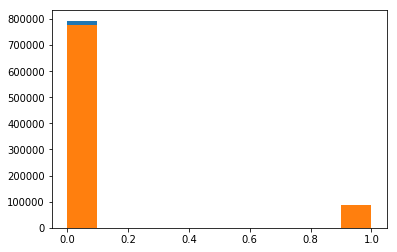

In [7]:
kk = model.predict(x_val,batch_size=batch_size,verbose=2)
print(kk)

print(kk.shape,y_val.shape)
plt.hist(np.round(kk))
plt.hist(y_val)
print(x_val.head())


In [8]:
print("Saved model to disk")
json_string = model.to_json()
with open("saved_models/model3.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('saved_models/weights3.h5')

Saved model to disk


In [9]:
print("predicting_test_sample")
dff = pd.read_csv('input_data/test_sampling5.csv')
print(dff.head())
dff, yy = clear_data(dff,'train')
dff = dff.drop(columns=['Unnamed: 0'])
output = model.predict(dff,batch_size=batch_size,verbose=2)


predicting_test_sample
   Unnamed: 0     ip  app  device  os  channel           click_time  \
0   178450426  63051   26       1  19      266  2017-11-09 14:00:13   
1   160852079  49602   26       2  19      266  2017-11-09 08:36:15   
2   118079796  25648    2       1   6      477  2017-11-08 14:49:12   
3   162379166   2965    8       1  19      140  2017-11-09 09:08:20   
4    84248176  20578   18       1  10      134  2017-11-08 04:33:53   

  attributed_time  is_attributed  
0             NaN              0  
1             NaN              0  
2             NaN              0  
3             NaN              0  
4             NaN              0  


[ 0.02147755  0.02132441  0.02098344 ...,  0.02757417  0.01982355
  0.01635614]
(18490389,)


(array([ 18445120.,         0.,         0.,         0.,         0.,
                0.,         0.,         0.,         0.,     45269.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

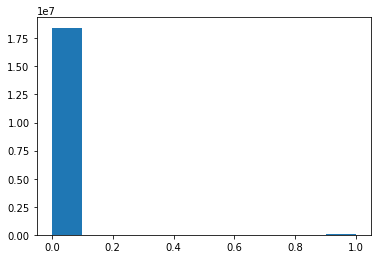

In [10]:
print(np.reshape(output,18490389))
print(yy.shape)
# dd = np.array([np.reshape(output,18490389),yy.values])

plt.hist(yy)



(array([  1.80809300e+07,   4.87810000e+04,   1.32610000e+04,
          6.48200000e+03,   9.18500000e+03,   1.09214000e+05,
          3.61520000e+04,   2.82370000e+04,   7.93810000e+04,
          7.87660000e+04]),
 array([ 0.0100796 ,  0.10771057,  0.20534153,  0.30297249,  0.40060345,
         0.49823441,  0.59586537,  0.69349634,  0.7911273 ,  0.88875826,
         0.98638922]),
 <a list of 10 Patch objects>)

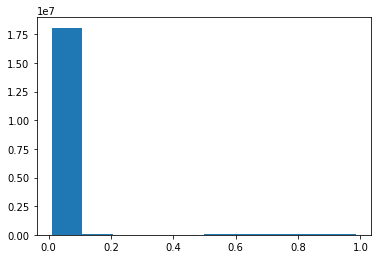

In [11]:
plt.hist(output)

In [12]:
print("predicting")
df_sub = pd.DataFrame()
ttest = pd.read_csv('input_data/kaggle_test.csv')
print("finish read test data")

ttest, idd = clear_data(ttest,'test')
df_sub['click_id'] = idd.astype('int32')
df_sub['is_attributed'] = model.predict(ttest,batch_size=batch_size,verbose=2)



predicting
finish read test data


check result
           click_id  is_attributed
count  1.879047e+07   1.879047e+07
mean   9.395234e+06   4.647657e-02
std    5.424341e+06   1.306664e-01
min    0.000000e+00   1.090885e-02
25%    4.697617e+06   1.802492e-02
50%    9.395234e+06   2.088001e-02
75%    1.409285e+07   2.534308e-02
max    1.879047e+07   9.869875e-01


(array([  1.80813440e+07,   2.47300000e+04,   2.77710000e+04,
          1.61280000e+04,   3.97840000e+04,   1.38464000e+05,
          1.05764000e+05,   1.41933000e+05,   1.12885000e+05,
          1.01666000e+05]),
 array([ 0.01090885,  0.10851671,  0.20612457,  0.30373244,  0.4013403 ,
         0.49894816,  0.59655602,  0.69416388,  0.79177175,  0.88937961,
         0.98698747]),
 <a list of 10 Patch objects>)

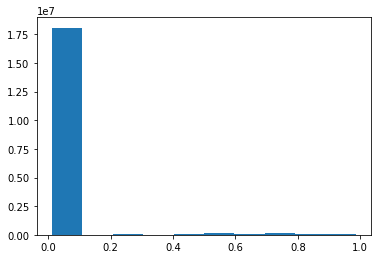

In [13]:
print("check result")
print(df_sub.describe())
plt.hist(df_sub['is_attributed'])

In [14]:
print("save the result")
df_sub.to_csv('sub_result/result_code3_sample5.csv',index=False)




save the result


(array([ 18190008.,         0.,         0.,         0.,         0.,
                0.,         0.,         0.,         0.,    600461.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

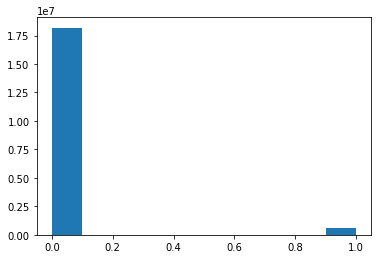

In [15]:
plt.hist(np.round(df_sub['is_attributed']))